In [27]:
!pip install w3lib

In [72]:
!pip install scattertext

     |████████████████████████████████| 6.9MB 2.8MB/s 


In [0]:
import pandas as pd
import numpy as np
import timeit

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from sklearn.feature_extraction.text import TfidfVectorizer
from w3lib.html import remove_tags
import spacy
from wordcloud import WordCloud
import scattertext as st

import matplotlib.pyplot as plt
import seaborn as sns

DATA_PATH = "/content/drive/My Drive/Colab Notebooks/movieReccomendation/dataset/IMDB Dataset.csv"

In [57]:
data = pd.read_csv(DATA_PATH)
print("shape of data", data.shape)

shape of data (50000, 3)


In [30]:
data.head(5)

,review,length of text,sentiment
0,Match 1: Tag Team Table Match Bubba Ray and Sp...,13704,positive
1,There's a sign on The Lost Highway that says:<...,12988,positive
2,"(Some spoilers included:)<br /><br />Although,...",12930,positive
3,"Back in the mid/late 80s, an OAV anime by titl...",12129,positive
4,**Attention Spoilers**<br /><br />First of all...,10363,positive


In [0]:
def token_filter(token):
    """Filter the token for text_preprocessing function.
    Check if the token is not: punctuation, whitespace, stopword or digit.
    
    Parameters
    ----------
    token : spacy.Token
        Token passed from text_preprocessing function.

    Returns
    -------
    Bool
       True if token meets the criteria, otherwise False.
        
    """
    return not (token.is_punct | token.is_space | token.is_digit | token.like_num | token.is_stop)

def text_preprocessing(df, batch_size, n_threads):
    """Perform text preprocessing using the following methods: removing HTML tags, lowercasing, 
    lemmatization whitespaces, punctuations, digits. 

    Parameters
    ----------
    df : pandas.Series
        Pandas.Series containing strings to process.
    batch_size: int
        Size of text batch (recommended to be the power of 2).
    n_threads: int
        Number of threads in multiprocessing.
        
    Returns
    -------
    pandas.Series
       Pandas.Series containing processed strings.
        
    """
    # Remove HTML tags
    df = df.apply(remove_tags)
    # Make lowercase
    df = df.str.lower()
    processed_docs = []
    for doc in list(nlp.pipe(df, batch_size=batch_size, n_threads=n_threads)):
        # Remove stopwords, spaces, punctutations and digits
        text = [token for token in doc if token_filter(token)]
        # Lemmatization
        text = [token.lemma_ for token in text if token.lemma_ != '-PRON-']
        processed_docs.append(' '.join(text))
    return pd.Series(processed_docs, name='clean_review', index=df.index)

In [58]:
# Define the variables
nlp = spacy.load('en_core_web_sm', disable = ['ner', 'parser', 'textcat', 'tagger', '...'])
batch_size = 500
n_threads = 2

# Test the processing time on a part of the trainig set, given batch_size and n_threads
print('Start processing 50000 text samples using batch_size: {} and n_threads: {}'.format(batch_size, n_threads))
start_time = timeit.default_timer()
data['clean_review']=text_preprocessing(data['review'], batch_size=batch_size, n_threads=n_threads)
print('Processing time: {:.2f} sec'.format(timeit.default_timer() - start_time))

Start processing 50000 text samples using batch_size: 500 and n_threads: 2
Processing time: 71.16 sec


In [59]:
data.head()

,review,length of text,sentiment,clean_review
0,Match 1: Tag Team Table Match Bubba Ray and Sp...,13704,positive,match tag team table match bubba ray spike dud...
1,There's a sign on The Lost Highway that says:<...,12988,positive,sign lose highway says:*major spoiler ahead*(b...
2,"(Some spoilers included:)<br /><br />Although,...",12930,positive,spoiler included:)although commentator call fi...
3,"Back in the mid/late 80s, an OAV anime by titl...",12129,positive,mid late 80s oav anime title bubblegum crisis ...
4,**Attention Spoilers**<br /><br />First of all...,10363,positive,attention spoilers**first let rob roy well fil...


In [0]:
#save the cleaned data to another file so that kernels above need not be run again
FILE_PATH = "/content/drive/My Drive/Colab Notebooks/movieReccomendation/dataset/"
data.to_csv(FILE_PATH+'cleaned_df.csv', index=False)

In [0]:
df = pd.read_csv(FILE_PATH+'cleaned_df.csv')

In [0]:
#plot WordClouds

# Load the language model
nlp = spacy.load('en_core_web_sm')

# Create the data frame that contains positive and neagtive reviews to visualize
pos_to_visual = df.loc[df.sentiment=='positive', ['clean_review', 'sentiment']].copy()
neg_to_visual = df.loc[df.sentiment=='negative', ['clean_review', 'sentiment']].copy()
data_to_visual = pd.concat([pos_to_visual, neg_to_visual], axis=0)

In [0]:
# Separate positive and negative reviews and then concatenate all reviews within given group
pos_reviews = ' '.join(data_to_visual.loc[data_to_visual.sentiment=='positive', 'clean_review'])
neg_reviews = ' '.join(data_to_visual.loc[data_to_visual.sentiment=='negative', 'clean_review'])

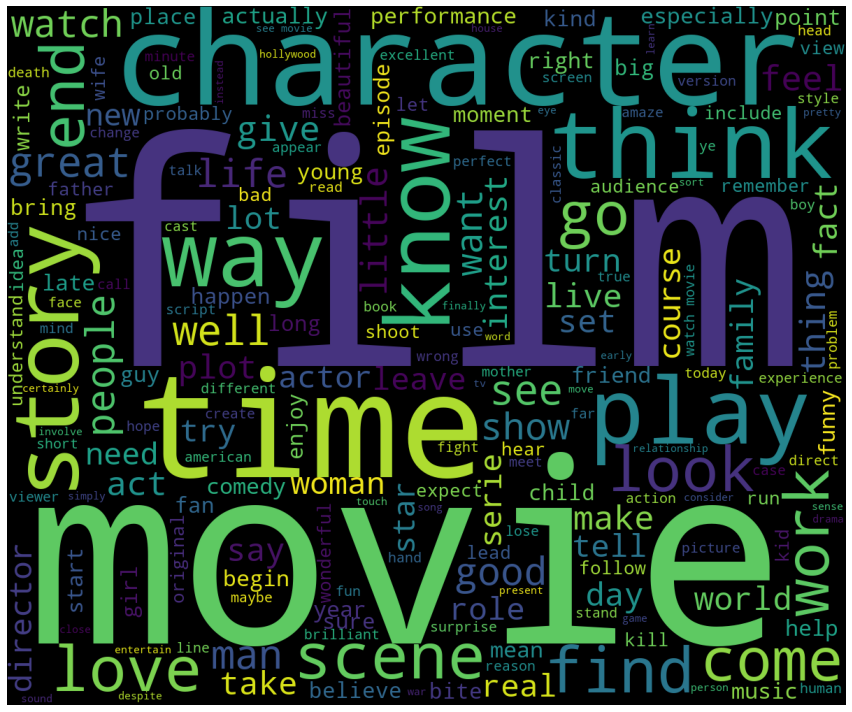

In [81]:
# Create wordcloud for positive reviews
wordcloud_pos = WordCloud(background_color='black',
                      width=1200,
                      height=1000).generate(pos_reviews)

plt.figure(figsize=(16,10))
plt.imshow(wordcloud_pos)
plt.axis('off')
plt.tight_layout()

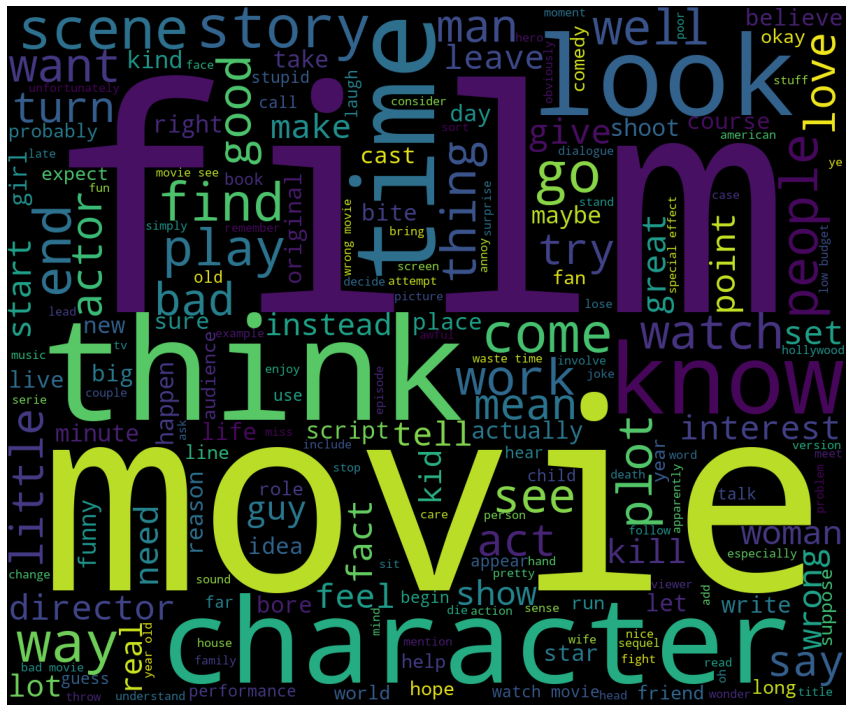

In [82]:
# Create wordcloud for positive reviews
wordcloud_neg = WordCloud(background_color='black',
                      width=1200,
                      height=1000).generate(neg_reviews)

plt.figure(figsize=(16,10))
plt.imshow(wordcloud_neg)
plt.axis('off')
plt.tight_layout()

In [0]:
X = df.drop(['review', 'length of text'], axis=1)

In [107]:
le = preprocessing.LabelEncoder()
X['sentiment'] = le.fit_transform(X['sentiment'])
print(X.head())

   sentiment                                       clean_review
0          1  match tag team table match bubba ray spike dud...
1          1  sign lose highway says:*major spoiler ahead*(b...
2          1  spoiler included:)although commentator call fi...
3          1  mid late 80s oav anime title bubblegum crisis ...
4          1  attention spoilers**first let rob roy well fil...


In [108]:
X_train, X_test_ = train_test_split(X, test_size=0.20, random_state=42)
print(f'shape of train data is {X_train.shape}')

shape of train data is (40000, 2)


In [0]:
X_val, X_test = train_test_split(X_test_, test_size=0.50, random_state=42)

In [0]:
PATH = "/content/drive/My Drive/Colab Notebooks/movieReccomendation/dataset/final_data/"
X_train.to_csv(PATH+'train.csv', index=False)
X_val.to_csv(PATH+'val.csv', index=False)
X_test.to_csv(PATH+'test.csv', index=False)